In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from heapq import heappush, heappop
from itertools import count
from networkx.algorithms.community.centrality import girvan_newman

In [2]:
def edge_betweenness_centrality(G,normalized=True):
  """
  Calculates the edge-betweenness-centrality score for each edge in graph G.

  Parameters
  ----------
  G : Graph input of type networkx graph object.
  normalized : Boolean True or False to normalize the betweeness score.

  Returns
  -------
  betweenness : List containing the betweenness score of all the edges
  """
  # Set betweenness of all vertices and edges as zero
  betweenness = dict.fromkeys(G, 0.0) 
  betweenness.update(dict.fromkeys(G.edges(), 0.0))

  nodes = G
  for node in nodes:
      S, parent, sigma = single_source_dijkstra(G, node)
      betweenness = get_betweenness(betweenness, S, parent, sigma, node)
  # remove nodes and keep edges
  for n in G:  
      del betweenness[n]
  betweenness = rescale_edges(betweenness, len(G), normalized=normalized, directed=G.is_directed())
  return betweenness

def single_source_dijkstra(G, node):
  """
  Performs Djikstra's shortest path algorithm to find the shortest path
  between the given node and all the other vertices in G

  Parameters
  ----------
  G : Graph input of type networkx graph object.
  node : Source node from which we find the shortest path to all the other vertices

  Returns
  -------
  S : List of nodes that were travered
  parent : List containing the parents of each node
  sigma :  List containing the number of shortest paths from node to all other vertices
  """
  S = []
  parent = {}
  for v in G:
      parent[v] = []
  sigma = dict.fromkeys(G, 0.0) 
  distance = {}
  sigma[node] = 1.0
  seen = {node: 0}
  c = count()
  Q = []
  heappush(Q, (0, next(c), node, node))
  while Q:
      (dist, _, pred, u) = heappop(Q)
      if u in distance:
          continue 
      sigma[u] += sigma[pred]
      S.append(u)
      distance[u] = dist
      for v, edgedata in G[u].items():
          uv_dist = dist + edgedata.get(None, 1)
          if v not in distance and (v not in seen or uv_dist < seen[v]):
              seen[v] = uv_dist
              heappush(Q, (uv_dist, next(c), u, v))
              sigma[v] = 0.0
              parent[v] = [u]
          elif uv_dist == seen[v]: 
              sigma[v] += sigma[u]
              parent[v].append(u)
  return S, parent, sigma


def get_betweenness(betweenness, S, parent, sigma, s):
  delta = dict.fromkeys(S, 0)
  while S:
      v = S.pop()
      coeff = (1 + delta[v]) / sigma[v]
      for u in parent[v]:
          c = sigma[u] * coeff
          if (u, v) not in betweenness:
              betweenness[(v, u)] += c
          else:
              betweenness[(u, v)] += c
          delta[u] += c
      if v != s:
          betweenness[v] += delta[v]
  return betweenness

def rescale_edges(betweenness, n, normalized, directed=False, k=None):
    if normalized:
        if n <= 1:
            scale = None
        else:
            scale = 1 / (n * (n - 1))
    else:  
        # divide by 2 for undirected graphs
        if not directed:
            scale = 0.5
        else:
            scale = None
    if scale is not None:
        if k is not None:
            scale = scale * n / k
        for u in betweenness:
            betweenness[u] *= scale
    return betweenness

In [3]:
def edge_to_remove(graph):
  ebc_per_edge = edge_betweenness_centrality(graph)
  edge = ()
  for key, value in sorted(ebc_per_edge.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break
  return edge

def girvan_newman(graph, num_communities):
  """
  Perform Girvan Neuman Divisive community detection 

  Parameters 
  ----------
  graph : Graph object of type networkx
  num_communities : Number of communities that we want to detect in the graph

  Returns
  -------
  cc_node_set : List conatining sets of connected components or communities detected
  removed_edges : Edges that were removed from the graph to get the connected componnets
  """
  cc_node_set = nx.connected_components(graph)
  cc_count = nx.number_connected_components(graph)
  removed_edges = []

  while(cc_count < num_communities):
    edge = edge_to_remove(graph)
    removed_edges.append(edge)
    graph.remove_edge(edge[0], edge[1])
    cc_node_set = nx.connected_components(graph)
    cc_count = nx.number_connected_components(graph)
  return cc_node_set, removed_edges

def get_remaining_edges(graph, removed_edges):
  for edge in removed_edges:
    if edge in graph.edges:
      graph.remove_edge(edge[0], edge[1])
  return graph

### Zachary's Karate Club

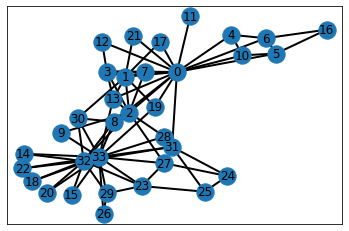

In [4]:
# Original Zachary's Karate Club graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G, k=0.1, iterations=30, scale=1.3)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos, width=2,alpha=1,edge_color='k')
plt.show()

In [17]:
def visualize_community_structure(num_communities, G):
  """
  Visualize the resulting communities detected in graph G with number of communities as num_communities
  """
  communities, removed_edges = girvan_newman(G,num_communities)
  G = get_remaining_edges(G, removed_edges)
  node_groups = []

  colors = ['yellow', 'green','blue','red','cyan']

  for i in communities:
    node_groups.append(list(i))

  color_map = []
  for node in G: 
    for i in range(len(node_groups)):
      if node in node_groups[i]:
        color_map.append(colors[i])  

  pos = nx.spring_layout(G, k=0.1, iterations=15, scale=10)
  nx.draw_networkx_nodes(G, pos=pos, node_color=color_map)
  nx.draw_networkx_labels(G, pos=pos)
  nx.draw_networkx_edges(G, pos=pos, edgelist=removed_edges, width=0.25, edge_color='k', style='dashed')
  nx.draw_networkx_edges(G, pos=pos, width=1,alpha=1,edge_color='k')
  plt.show()

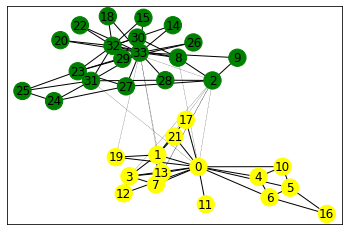

In [18]:
# Zachary's Karate Club graph with 2 communities
visualize_community_structure(num_communities=2, G = nx.karate_club_graph())

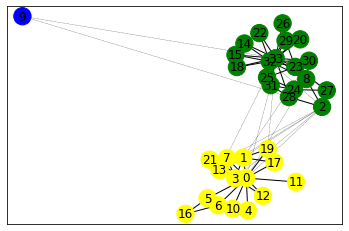

In [19]:
# Zachary's Karate Club graph with 3 communities
visualize_community_structure(num_communities=3, G = nx.karate_club_graph())

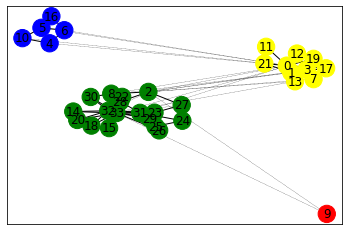

In [20]:
# Zachary's Karate Club graph with 4 communities
visualize_community_structure(num_communities=4, G = nx.karate_club_graph())

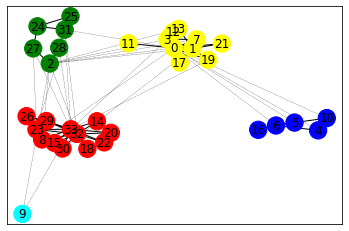

In [21]:
# Zachary's Karate Club graph with 5 communities
visualize_community_structure(num_communities=5, G = nx.karate_club_graph())

### Planted L-Partition

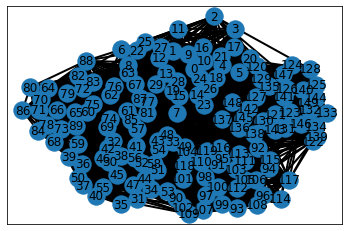

In [22]:
# Original Planted L-Partition Graph
G = nx.planted_partition_graph(5,30,0.8,0.1)
pos = nx.spring_layout(G, k=0.1, iterations=30, scale=1.3)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos, width=2,alpha=1,edge_color='k')
plt.show()

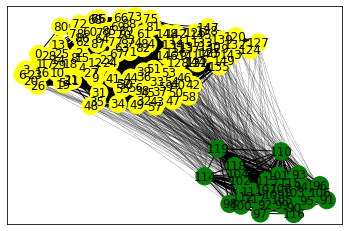

In [23]:
# Planted L-Partition Graph graph with 2 communities
visualize_community_structure(num_communities=2, G = nx.planted_partition_graph(5,30,0.8,0.1))

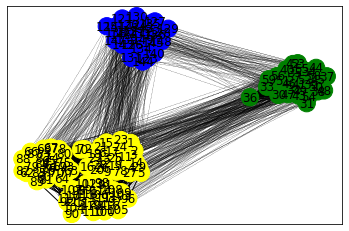

In [24]:
# Planted L-Partition Graph graph with 3 communities
visualize_community_structure(num_communities=3, G = nx.planted_partition_graph(5,30,0.8,0.1))

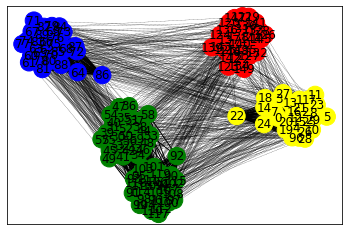

In [25]:
# Planted L-Partition Graph graph with 4 communities
visualize_community_structure(num_communities=4, G = nx.planted_partition_graph(5,30,0.8,0.1))

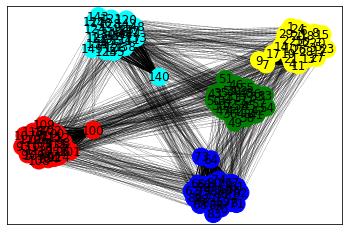

In [26]:
# Planted L-Partition Graph graph with 5 communities
visualize_community_structure(num_communities=5, G = nx.planted_partition_graph(5,30,0.8,0.1))